In [1]:
import matplotlib.pyplot as plt

from mlxtend.data import loadlocal_mnist
import platform

In [2]:
X_train, y_train = loadlocal_mnist(
    images_path='data/train-images-idx3-ubyte', 
    labels_path='data/train-labels-idx1-ubyte')
X_test, y_test = loadlocal_mnist(
    images_path='data/t10k-images-idx3-ubyte', 
    labels_path='data/t10k-labels-idx1-ubyte')

Text(0.5, 1.0, '5')

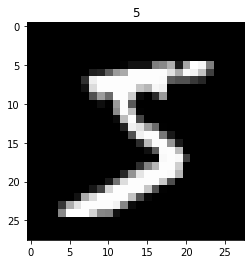

In [3]:
X_train.shape
plt.imshow(X_train[0].reshape(28, 28), cmap="gray")
plt.title(y_train[0])

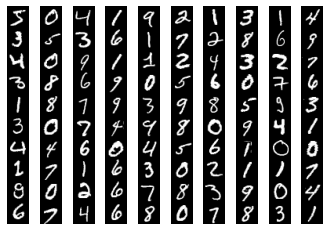

In [4]:
fig, axs = plt.subplots(10, 10) # figsize(20, 20)

for row in range(10):
    for col in range(10):
        axs[row][col].imshow(X_train[row * 10 + col].reshape(28, 28), cmap="gray")
        axs[row][col].axis("off")

plt.subplots_adjust(wspace=-0.2, hspace=0)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
BATCH_SIZE = 64         # number of data points in each batch
N_EPOCHS = 100           # times to run the model on complete data
INPUT_DIM = 28 * 28     # size of each input
HIDDEN_DIM = 256        # hidden dimension
LATENT_DIM = 10         # latent vector dimension
lr = 1e-3               # learning rate

In [8]:
X_train = torch.tensor(X_train / 255, dtype=torch.float64)
y_train = torch.tensor(y_train).reshape(y_train.shape[0], 1)
X_test = torch.tensor(X_test / 255, dtype=torch.float64)
y_test = torch.tensor(y_test).reshape(y_test.shape[0], 1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([60000, 784]) torch.Size([60000, 1])
torch.Size([10000, 784]) torch.Size([10000, 1])


In [9]:
train_data = []
for i in range(len(X_train)):
   train_data.append([X_train[i], y_train[i]])

test_data = []
for i in range(len(X_train)):
   test_data.append([X_train[i], y_train[i]])

In [10]:
train_iterator = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
class Encoder(nn.Module):
    ''' This the encoder part of VAE

    '''
    def __init__(self, input_dim, hidden_dim, z_dim):
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            hidden_dim: A integer indicating the size of hidden dimension.
            z_dim: A integer indicating the latent dimension.
        '''
        super().__init__()

        self.linear = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.var = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        # x is of shape [batch_size, input_dim]

        hidden = F.relu(self.linear(x))
        # hidden is of shape [batch_size, hidden_dim]
        z_mu = self.mu(hidden)
        # z_mu is of shape [batch_size, latent_dim]
        z_var = self.var(hidden)
        # z_var is of shape [batch_size, latent_dim]

        return z_mu, z_var

In [12]:
class Decoder(nn.Module):
    ''' This the decoder part of VAE

    '''
    def __init__(self, z_dim, hidden_dim, output_dim):
        '''
        Args:
            z_dim: A integer indicating the latent size.
            hidden_dim: A integer indicating the size of hidden dimension.
            output_dim: A integer indicating the output dimension (in case of MNIST it is 28 * 28)
        '''
        super().__init__()

        self.linear = nn.Linear(z_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x is of shape [batch_size, latent_dim]

        hidden = F.relu(self.linear(x))
        # hidden is of shape [batch_size, hidden_dim]

        predicted = torch.sigmoid(self.out(hidden))
        # predicted is of shape [batch_size, output_dim]

        return predicted

In [13]:
class VAE(nn.Module):
    ''' This the VAE, which takes a encoder and decoder.

    '''
    def __init__(self, enc, dec):
        super().__init__()

        self.enc = enc
        self.dec = dec

    def forward(self, x):
        # encode
        z_mu, z_var = self.enc(x)

        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(z_mu)

        # decode
        predicted = self.dec(x_sample)
        return predicted, z_mu, z_var

In [14]:
 # encoder
encoder = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM).type(torch.float64)

# decoder
decoder = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM).type(torch.float64)

# vae
model = VAE(encoder, decoder).to(device).type(torch.float64)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [15]:
def train():
    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0

    for i, (x, _) in enumerate(train_iterator):
        # reshape the data into [batch_size, 784]
        x = x.view(-1, 28 * 28)
        x = x.to(device)

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        x_sample, z_mu, z_var = model(x)

        # reconstruction loss
        recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)

        # kl divergence loss
        kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

        # total loss
        loss = recon_loss + kl_loss

        # backward pass
        loss.backward()
        train_loss += loss.item()

        # update the weights
        optimizer.step()

    return train_loss

In [16]:
def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    # we don't need to track the gradients, since we are not updating the parameters during evaluation / testing
    with torch.no_grad():
        for i, (x, _) in enumerate(test_iterator):
            # reshape the data
            x = x.view(-1, 28 * 28)
            x = x.to(device)

            # forward pass
            x_sample, z_mu, z_var = model(x)

            # reconstruction loss
            recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)

            # kl divergence loss
            kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

            # total loss
            loss = recon_loss + kl_loss
            test_loss += loss.item()

    return test_loss


In [17]:
train_losses = []
test_losses = []

for e in range(N_EPOCHS):

    train_loss = train()
    test_loss = test()

    train_loss /= len(X_train)
    train_losses.append(train_loss)
    test_loss /= len(X_test)
    test_losses.append(test_loss)

    print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0, Train Loss: 154.34, Test Loss: 765.70
Epoch 1, Train Loss: 123.63, Test Loss: 724.92
Epoch 2, Train Loss: 119.01, Test Loss: 704.94
Epoch 3, Train Loss: 116.62, Test Loss: 693.66
Epoch 4, Train Loss: 115.11, Test Loss: 686.09
Epoch 5, Train Loss: 114.08, Test Loss: 682.64
Epoch 6, Train Loss: 113.25, Test Loss: 676.04
Epoch 7, Train Loss: 112.63, Test Loss: 673.04
Epoch 8, Train Loss: 112.09, Test Loss: 669.88
Epoch 9, Train Loss: 111.59, Test Loss: 667.00
Epoch 10, Train Loss: 111.23, Test Loss: 666.24
Epoch 11, Train Loss: 110.88, Test Loss: 662.99
Epoch 12, Train Loss: 110.53, Test Loss: 661.18
Epoch 13, Train Loss: 110.25, Test Loss: 659.30
Epoch 14, Train Loss: 109.96, Test Loss: 659.16
Epoch 15, Train Loss: 109.74, Test Loss: 657.24
Epoch 16, Train Loss: 109.52, Test Loss: 655.13
Epoch 17, Train Loss: 109.33, Test Loss: 654.03
Epoch 18, Train Loss: 109.11, Test Loss: 654.77
Epoch 19, Train Loss: 108.98, Test Loss: 652.56
Epoch 20, Train Loss: 108.82, Test Loss: 650.26
Ep

Text(0, 0.5, 'Loss')

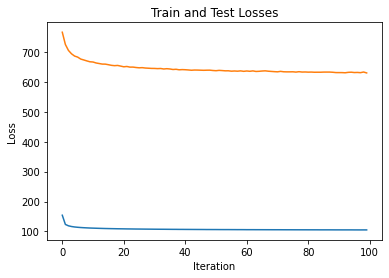

In [18]:
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.title("Train and Test Losses")
plt.xlabel("Iteration")
plt.ylabel("Loss")

In [19]:
gen_images = []

for i in range(100):
    # sample and generate a image
    z = torch.randn(1, LATENT_DIM).to(device).type(torch.float64)

    # run only the decoder
    reconstructed_img = model.dec(z)
#     img = reconstructed_img
    gen_images.append(reconstructed_img.detach().numpy())

#     print(z.shape)
#     print(img.shape)

#     plt.imshow(img, cmap='gray')

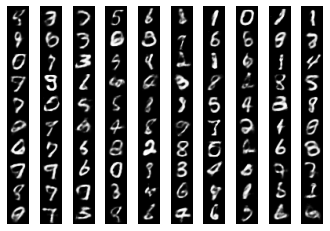

In [20]:
fig, axs = plt.subplots(10, 10) # figsize(20, 20)

for row in range(10):
    for col in range(10):
        axs[row][col].imshow(gen_images[row * 10 + col].reshape(28, 28), cmap="gray")
        axs[row][col].axis("off")

plt.subplots_adjust(wspace=-0.2, hspace=0)